In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


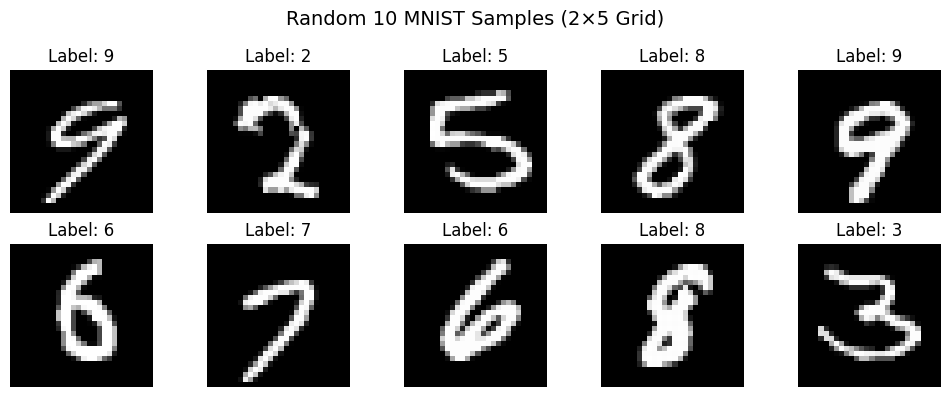

In [2]:
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))



# Select 10 random samples
indices = np.random.choice(len(x_train), 10, replace=False)
sample_images = x_train[indices]
sample_labels = y_train[indices]

# Plot in 2x5 grid
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis('off')

plt.suptitle("Random 10 MNIST Samples (2×5 Grid)", fontsize=14)
plt.tight_layout()
plt.show()

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7637 - loss: 0.3182
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8001 - loss: 0.1792
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8043 - loss: 0.1574
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8062 - loss: 0.1470
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8073 - loss: 0.1405
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8080 - loss: 0.1364
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8086 - loss: 0.1330
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8089 - loss: 0.1306
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8088 - loss: 0.1287
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8094 - loss: 0.1270
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8099 - loss: 0.1255
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

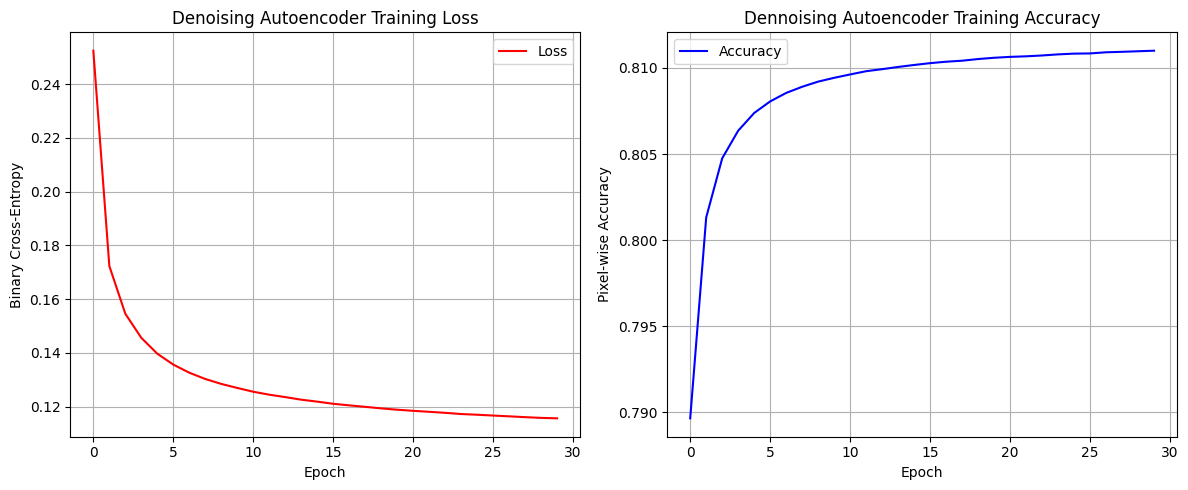

In [3]:
# Add noise to training images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

# Denoising Autoencoder Architecture
latent_dim = 64

# Encoder
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
encoded = Dense(latent_dim, activation='relu')(x)

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(decoder_input)
x = Dense(256, activation='relu')(x)
x = Dense(28 * 28, activation='sigmoid')(x)
decoded = Reshape((28, 28, 1))(x)

# Models
encoder = Model(input_img, encoded, name="Encoder")
decoder = Model(decoder_input, decoded, name="Decoder")

# Full Denoising Autoencoder
autoencoder_input = Input(shape=(28, 28, 1))
encoded_img = encoder(autoencoder_input)
reconstructed_img = decoder(encoded_img)
autoencoder = Model(autoencoder_input, reconstructed_img)

# Compile and Train the Denoising Autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = autoencoder.fit(x_train_noisy, x_train, epochs=30, batch_size=256, shuffle=True)


plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss', color='red')
plt.title('Denoising Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
plt.title('Dennoising Autoencoder Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Pixel-wise Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8334 - loss: 0.5891 - val_accuracy: 0.9803 - val_loss: 0.0696
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9763 - loss: 0.0761 - val_accuracy: 0.9855 - val_loss: 0.0527
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9851 - loss: 0.0487 - val_accuracy: 0.9872 - val_loss: 0.0427
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9883 - loss: 0.0399 - val_accuracy: 0.9875 - val_loss: 0.0421
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9911 - loss: 0.0282 - val_accuracy: 0.9895 - val_loss: 0.0397
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9926 - loss: 0.0253 - val_accuracy: 0.9878 - val_loss: 0.0400
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9929 - loss: 0.0217 - val_accuracy: 0.9905 - val_loss: 0.0351
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9948 - loss: 0.0180 - val_accuracy: 0

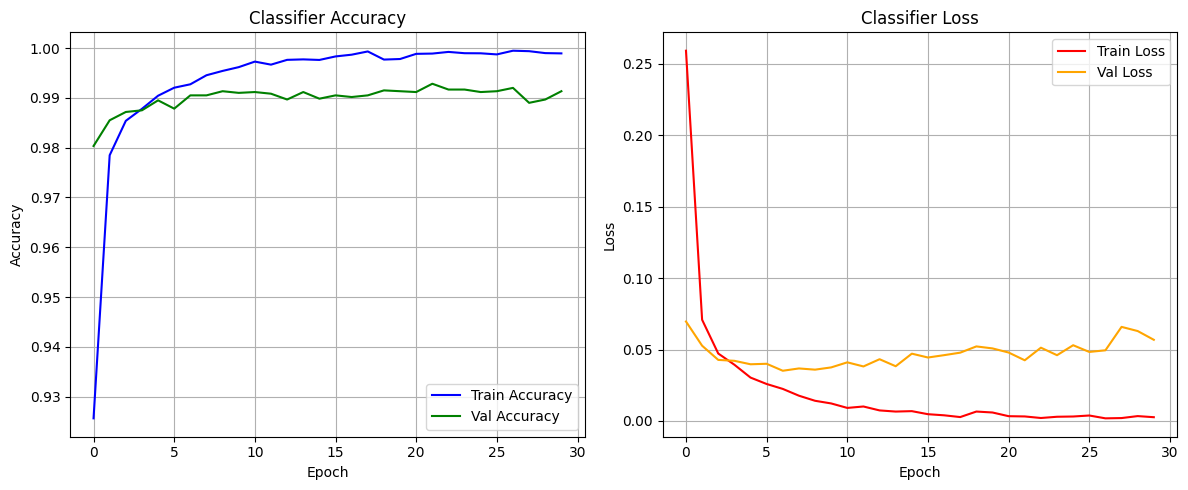

In [4]:
# CNN Classifier (same as before)
input_cls = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu')(input_cls)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output_cls = Dense(10, activation='softmax')(x)

classifier = Model(inputs=input_cls, outputs=output_cls)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = classifier.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.1)


# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='green')
plt.title('Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Sampled noise vectors (N(5, 1)): 

Noise Vector 1:
[5.87 6.95 4.46 5.21 5.78 7.14 5.98 5.29 6.32 4.73 2.75 4.26 5.79 5.6
 5.04 4.73 3.09 3.03 6.18 4.19 3.43 2.9  5.37 5.5  4.97 5.77 5.45 3.89
 6.03 6.5  3.81 3.79 4.53 4.23 5.7  5.41 3.91 5.78 3.94 4.8  6.51 5.1
 4.94 3.49 3.64 4.76 4.75 4.51 6.06 4.18 5.04 4.24 6.31 5.62 3.83 6.47
 6.36 3.06 3.99 6.4  5.08 4.72 6.91 3.5 ]

Noise Vector 2:
[5.51 4.89 4.85 4.58 4.45 4.51 3.2  3.64 4.12 6.12 3.89 4.86 4.7  6.29
 3.81 4.48 5.66 4.77 3.79 5.67 5.23 6.14 6.32 5.35 5.84 5.44 4.95 3.93
 7.06 3.73 4.08 4.36 3.68 4.97 5.64 4.83 7.03 5.49 2.28 4.16 5.14 6.34
 5.52 3.28 4.17 4.55 5.38 6.25 4.58 4.84 7.49 5.81 4.88 4.51 4.94 3.04
 4.06 5.62 4.23 5.06 5.56 3.88 4.55 5.22]

Noise Vector 3:
[4.02 4.32 5.69 4.06 4.93 5.2  5.18 6.41 5.71 3.48 5.21 4.08 6.29 5.3
 4.87 5.59 4.92 5.03 5.42 5.91 4.07 5.39 6.51 5.74 6.02 6.42 4.28 6.3
 5.24 6.58 5.54 4.6  4.01 4.31 4.64 5.68 4.22 4.82 5.7  4.14 4.57 5.2
 5.01 5.33 5.57 6.18 4.2  3.68 4.66 5.3  5.61 6.86 6.16

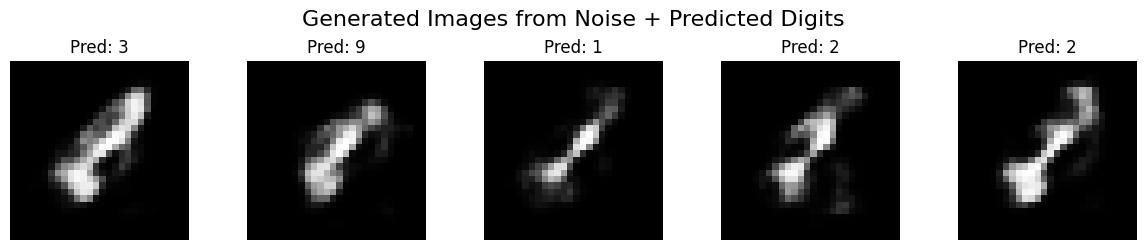

In [5]:
# Sample Noise Vectors with mean = 5
mean = 5
std_dev = 1
noise_vectors = np.random.normal(loc=mean, scale=std_dev, size=(5, latent_dim))

print("Sampled noise vectors (N({}, {})): \n".format(mean, std_dev))
for i, vec in enumerate(noise_vectors):
    print(f"Noise Vector {i+1}:")
    print(np.round(vec, 2))
    print()

# Generate Images from Decoder
generated_images = decoder.predict(noise_vectors)

# Predict Labels Using Classifier
predicted_labels = classifier.predict(generated_images)
predicted_digits = np.argmax(predicted_labels, axis=1)

# Display the Generated Images with Predicted Labels
plt.figure(figsize=(12, 2.5))
for i, img in enumerate(generated_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Pred: {predicted_digits[i]}")
    plt.axis('off')
plt.suptitle("Generated Images from Noise + Predicted Digits", fontsize=16)
plt.tight_layout()
plt.show()
